In [1]:
import allel
import loompy
import numpy as np
import pandas as pd
import pysam
import seaborn as sns
import matplotlib.pyplot as plt
import math
import itertools
from collections import Counter
from collections import defaultdict

import mb_funcs as mb
%load_ext autoreload
%autoreload 2

plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

In [170]:
mskcc_loomfile = '/n/fs/ragr-data/datasets/mskcc_iacobuzio/RA17_22/tapestri/RA17_22_39_2_IGO_11988_E_1/RA17_22_39_2_IGO_11988_E_1.cells.loom'

with loompy.connect(mskcc_loomfile) as ds:
    print(ds.attrs.keys())
    print(ds.shape)

['CreationDate', 'LOOM_SPEC_VERSION', 'allsites_block', 'chemistry', 'coverage', 'genome_version', 'last_modified', 'mb_loom_version', 'n_reads', 'n_reads_per_cell', 'pipeline_version']
(39772, 635)


In [171]:
ds = loompy.connect(mskcc_loomfile)

In [173]:
ds.close()

#### data overview

In [5]:
for key in ds.attrs.keys():
    print(f'{key}: {ds.attrs[key]}')

CreationDate: 20210720T090716.565260Z
LOOM_SPEC_VERSION: 2.0.1
allsites_block: 3495
chemistry: V2
coverage: 530
genome_version: hg19
last_modified: 20210720T090716.561603Z
mb_loom_version: 2.2
n_reads: 309597930
n_reads_per_cell: 98526
pipeline_version: 2.0.1


In [6]:
ds.layers.keys()

['', 'AD', 'DP', 'GQ', 'RO']

In [7]:
def generate_heatmap(data):
#     fig, ax = plt.subplots(1,1)
    g = sns.clustermap(data, row_cluster=False, col_cluster=False)
    g.ax_heatmap.set_ylabel('SNVs', fontsize=20)
    g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### What is the number of cells, positions, amplicons?

In [8]:
print(f"number of covered positions is {ds.shape[0]}")
print(f"number of cells is {ds.shape[1]}")
print(f"number of amplicons is {len(np.unique(ds.ra['amplicon']))}")
print(f"number of chromosomes is {len(np.unique(ds.ra['CHROM']))}")

number of covered positions is 39772
number of cells is 635
number of amplicons is 186
number of chromosomes is 22


#### Q: what is nonref_cells in row attributes?

In [9]:
ds.ra.keys()

['ALT',
 'CHROM',
 'CLNDEF',
 'COMMON',
 'POS',
 'QUAL',
 'REF',
 'RSID',
 'amplicon',
 'id',
 'nonref_cells']

In [10]:
pd.Series(ds.ra['nonref_cells']).value_counts()

0      18296
1       9998
2       5148
3       2467
4       1303
       ...  
118        1
60         1
490        1
481        1
134        1
Length: 226, dtype: int64

#### position dataframe

In [11]:
df_pos = pd.DataFrame({'pos': list(ds.ra['POS']),
                       'chrom': list(ds.ra['CHROM']),
                       'amplicon': list(ds.ra['amplicon']),
                       'ref': list(ds.ra['REF']),
                       'alt': list(ds.ra['ALT'])})

df_pos['ref_len'] = df_pos['ref'].apply(len)
df_pos['alt_len'] = df_pos['alt'].apply(len)
df_pos['normal'] = (df_pos['ref_len'] == 1) & (df_pos['alt_len'] == 1)

df_pos['index'] = df_pos.index

In [24]:
df_pos

,pos,chrom,amplicon,ref,alt,ref_len,alt_len,normal,index
0,27057593,1,AMPL50980,T,C,1,1,True,0
1,27057623,1,AMPL50980,T,C,1,1,True,1
2,27057623,1,AMPL50980,T,A,1,1,True,2
3,27057628,1,AMPL50980,T,C,1,1,True,3
4,27057628,1,AMPL50980,T,A,1,1,True,4
...,...,...,...,...,...,...,...,...,...
39767,76777892,X,AMPL70504,T,C,1,1,True,39767
39768,76777892,X,AMPL70504,T,A,1,1,True,39768
39769,76777893,X,AMPL70504,T,C,1,1,True,39769
39770,76777894,X,AMPL70504,C,T,1,1,True,39770


In [25]:
df_pos[df_pos['pos'] == 27057726]

,pos,chrom,amplicon,ref,alt,ref_len,alt_len,normal,index
3690,27057726,1,AMPL50980,TCAG,T,4,1,False,3690
3691,27057726,1,AMPL50980,T,A,1,1,True,3691


(array([599.,  27.,   2.,   3.,   2.,   0.,   1.,   0.,   0.,   1.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

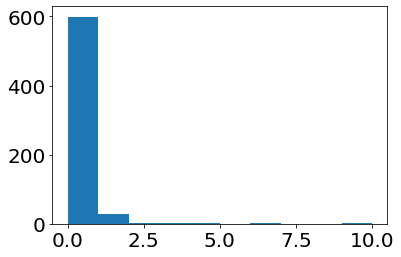

In [26]:
plt.hist(ds.layers['AD'][4,:])

(array([620.,   7.,   6.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

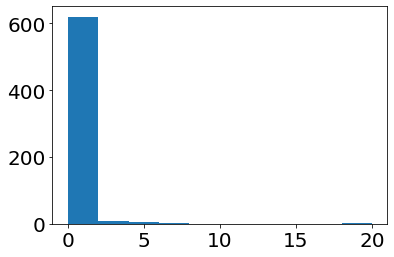

In [27]:
plt.hist(ds.layers['AD'][3,:])

(array([3.2224e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.7290e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+01]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

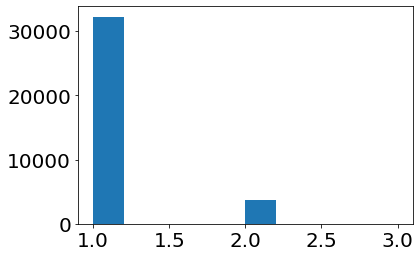

In [28]:
plt.hist(df_pos.groupby(['pos', 'amplicon'])['index'].count().values)

In [29]:
df_unique_pos = df_pos.groupby(['pos', 'amplicon']).last().reset_index()

In [30]:
len(df_unique_pos)

35983

In [31]:
df_unique_pos

,pos,amplicon,chrom,ref,alt,ref_len,alt_len,normal,index
0,346979,AMPL87363,16,T,C,1,1,True,27572
1,346980,AMPL87363,16,G,A,1,1,True,27573
2,346981,AMPL87363,16,C,T,1,1,True,27574
3,346982,AMPL87363,16,A,G,1,1,True,27575
4,346983,AMPL87363,16,C,,1,0,False,27576
...,...,...,...,...,...,...,...,...,...
35978,198266798,AMPL87266,2,A,G,1,1,True,8725
35979,198266799,AMPL87266,2,GGCA,,4,0,False,8726
35980,198266800,AMPL87266,2,G,,1,0,False,8727
35981,198266801,AMPL87266,2,C,T,1,1,True,524


#### What is the actual number of positions?

In [32]:
print(f"Total number of positions is {len(df_unique_pos)}")

Total number of positions is 35983


#### What is the number of positions covered in each chromosome?

In [33]:
df_unique_pos['chrom'].value_counts()

17    4277
12    2943
3     2684
2     2682
7     2620
1     2462
X     2340
11    2150
19    1764
18    1468
5     1423
10    1326
6     1283
16    1186
4     1020
9      921
20     861
15     827
8      799
13     583
22     207
14     157
Name: chrom, dtype: int64

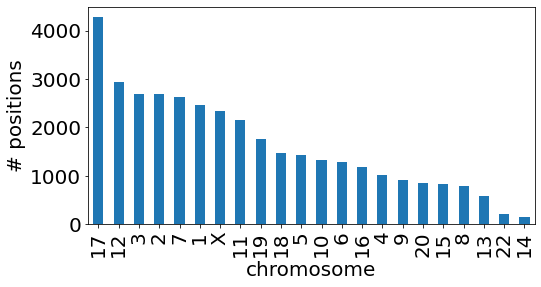

In [34]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# positions');

#### what is the number of amplicons in each chromosome?

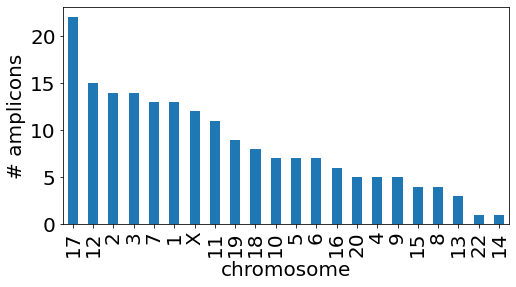

In [35]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos.groupby('amplicon').first()['chrom'].value_counts().plot.bar()
plt.gca().set_xlabel('chromosome');
plt.gca().set_ylabel('# amplicons');

#### what is the number of positions in each amplicon

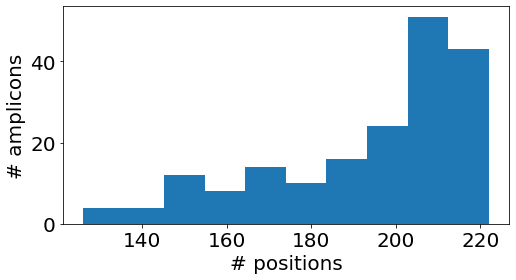

In [36]:
fig, ax = plt.subplots(1,1,figsize=(8,4))
df_unique_pos['amplicon'].value_counts().plot.hist()
plt.gca().set_ylabel('# amplicons');
plt.gca().set_xlabel('# positions');

#### what is the coverage across cells?

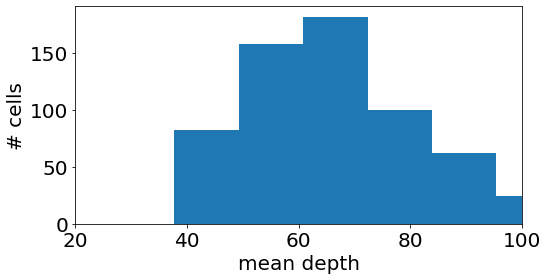

In [37]:
(mean_coverage, ) = ds.layers['DP'].map([np.mean], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(mean_coverage);
plt.gca().set_xlabel('mean depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

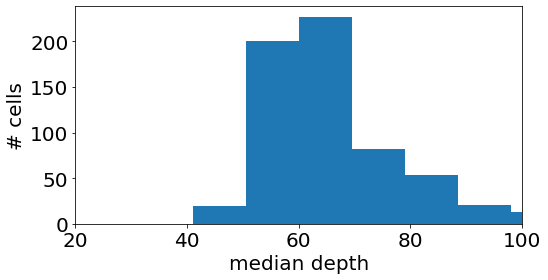

In [38]:
(median_coverage, ) = ds.layers['DP'].map([np.median], axis=1)
fig, ax = plt.subplots(1,1,figsize=(8,4))
plt.hist(median_coverage);
plt.gca().set_xlabel('median depth');
plt.gca().set_ylabel('# cells');
plt.gca().set_xlim((20, 100));

#### how much does read depth vary within each amplicon?

For each cell $i$ we look at the max read depth $M_{ij}$ and the min read depth $m_{ij}$ across all positions in amplicon $j$. <br>
Then we compute $m_{ij}/M_{ij}$. This is the most extreme factor by which the copy number estimate will vary for positions within amplicon $j$ in cell $i$.

We expect this number to be close to 1 because the read lengths should be comparable with the amplicon lengths. <br>

In [39]:
amplicon_list = list(df_unique_pos['amplicon'].unique())

namplicons = len(amplicon_list)

df_unique_pos = df_unique_pos.sort_values('index')

In [40]:
trim_perc = 0
empty_cells_median = np.zeros((namplicons, 1))

for idx, amplicon in enumerate(amplicon_list):
    selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values
    npos = len(selected_indices)
    if trim_perc > 0:
        cutoff = int(npos // (100 / trim_perc))
    else:
        cutoff = 0
    
    a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]

    median_depths = np.median(a, axis = 0)
    empty_cells_median[idx] = sum(median_depths == 0)

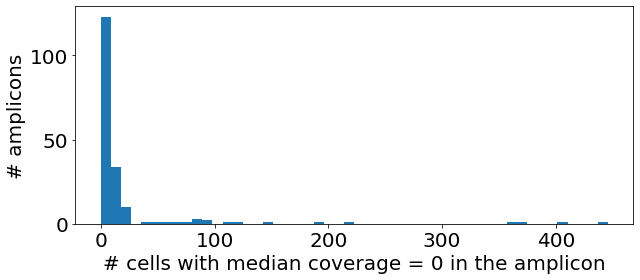

In [41]:
fig, ax = plt.subplots(1,1,figsize=(10,4))
plt.hist(empty_cells_median, bins = 50)
plt.gca().set_ylabel('# amplicons', fontsize=20)
plt.gca().set_xlabel('# cells with median coverage = 0 in the amplicon', );

In [42]:
mb_analyzer = mb.analyzer(ds)

rejected 16 cells for amplicon AMPL87363
rejected 55 cells for amplicon AMPL87294
rejected 10 cells for amplicon AMPL87377
rejected 6 cells for amplicon AMPL87244
rejected 4 cells for amplicon AMPL87358


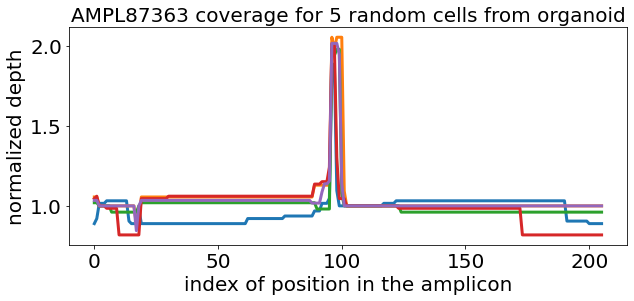

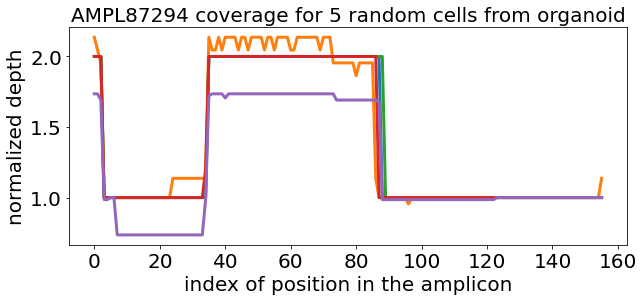

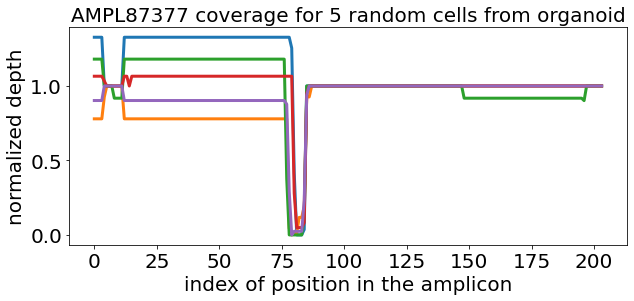

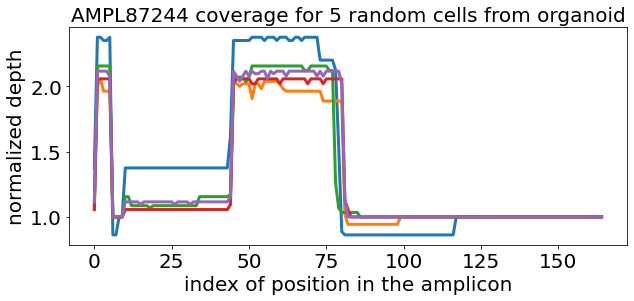

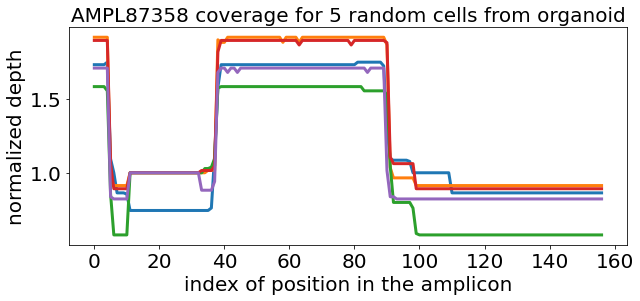

In [43]:
mb_analyzer.plot_amplicon_coverage(amplicon_list[0])
mb_analyzer.plot_amplicon_coverage(amplicon_list[4])
mb_analyzer.plot_amplicon_coverage(amplicon_list[20])
mb_analyzer.plot_amplicon_coverage(amplicon_list[43])
mb_analyzer.plot_amplicon_coverage(amplicon_list[140])

rejected 16 cells for amplicon AMPL87363
rejected 55 cells for amplicon AMPL87294
rejected 10 cells for amplicon AMPL87377
rejected 6 cells for amplicon AMPL87244
rejected 4 cells for amplicon AMPL87358


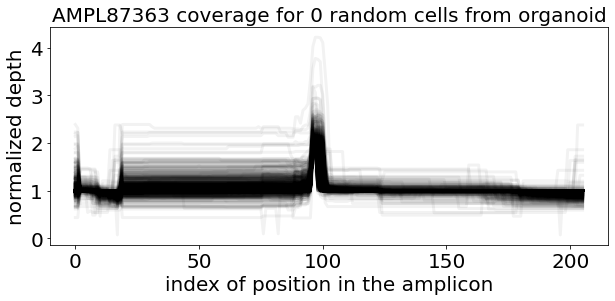

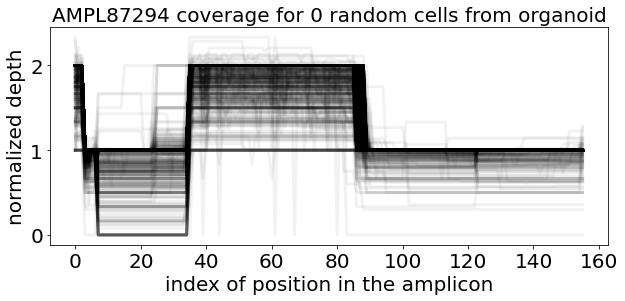

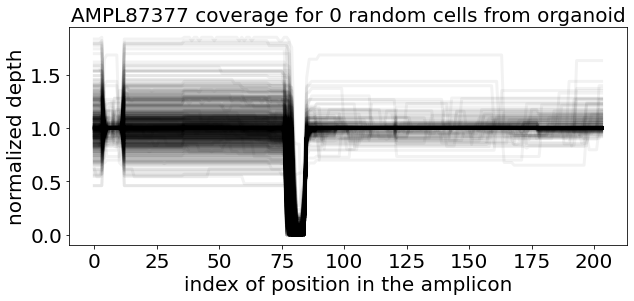

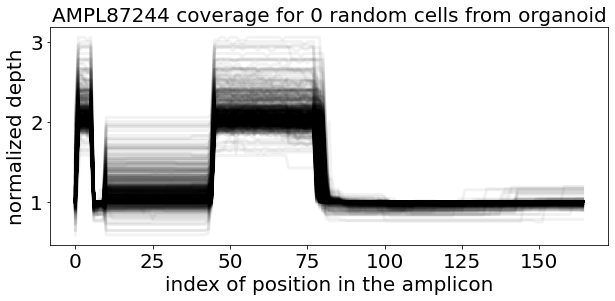

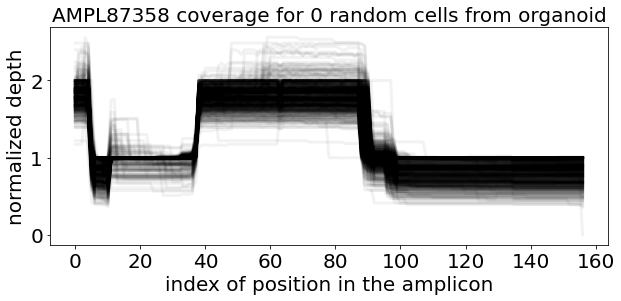

In [44]:
mb_analyzer.plot_amplicon_coverage(amplicon_list[0], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[4], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[20], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[43], nprobe = 0)
mb_analyzer.plot_amplicon_coverage(amplicon_list[140], nprobe = 0)

In [45]:
def plot_cell_coverage(cell_idx, nprobe = None, norm_flag = True, trim_perc = 0):

    depth_values = []
    pos_values = []
    prev_npos = 0
    breakpoint_locs = []
    namplicon = len(amplicon_list)
    if nprobe:
        np.random.seed(cell_idx)
        selected_amplicon_list = [amplicon_list[x] for x in np.random.randint(namplicon, size=nprobe)]
    else:
        selected_amplicon_list = amplicon_list.copy()
        
    for amplicon in selected_amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], cell_idx]    


        if norm_flag:
            median_depth =  np.median(a)
            if median_depth == 0:
                a = np.zeros(a.shape)
            else:
                a = a / np.median(a)

        depth_values += list(a)
        pos_values += list(prev_npos + np.arange(npos))
        prev_npos += npos
        breakpoint_locs.append(prev_npos)
        
    fig, ax = plt.subplots(1,1,figsize=(40,4))
    plt.plot(pos_values, depth_values, linewidth=3)
    for idx in range(len(selected_amplicon_list)):
        plt.axvline(breakpoint_locs[idx], color='r')

    plt.gca().set_ylabel('read depth')
    plt.gca().set_xlabel('position index')  
    plt.xlim((0, prev_npos))
    
    if not nprobe:
        plt.title(f"coverage for all amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)
    else:
        plt.title(f"coverage for {nprobe} random amplicons {'with' if norm_flag else 'without'} normalization", fontsize=20)

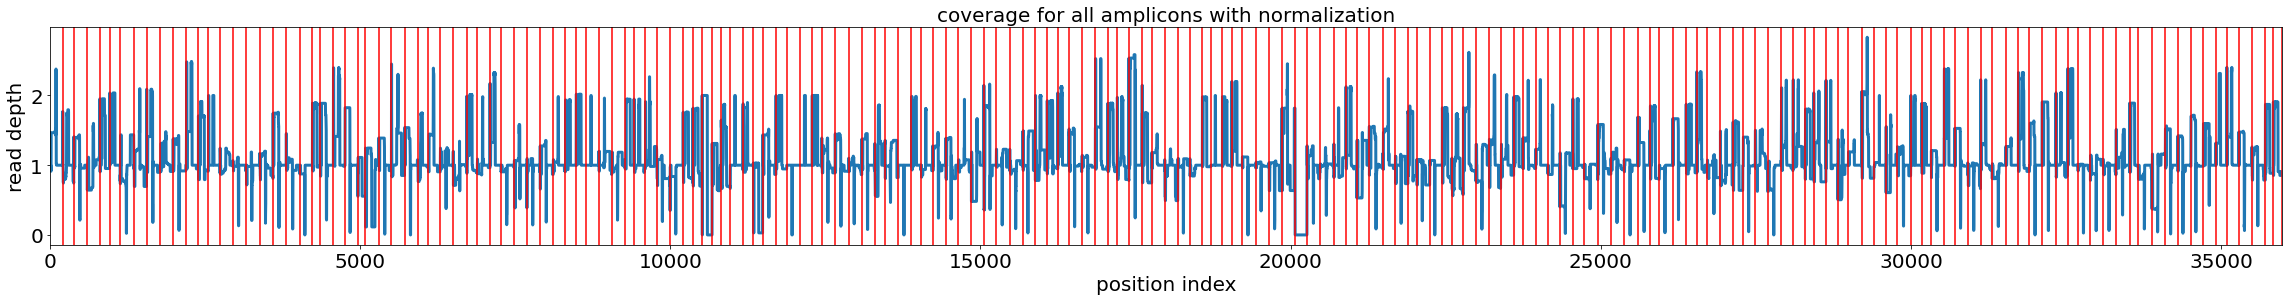

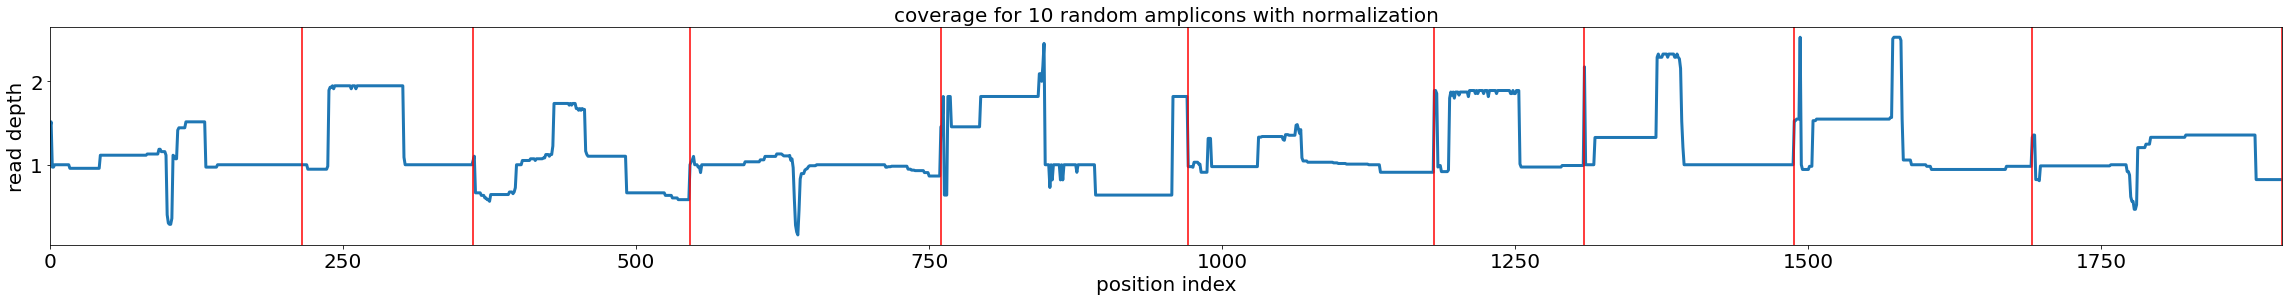

In [46]:
plot_cell_coverage(0)
plot_cell_coverage(0, nprobe = 10)

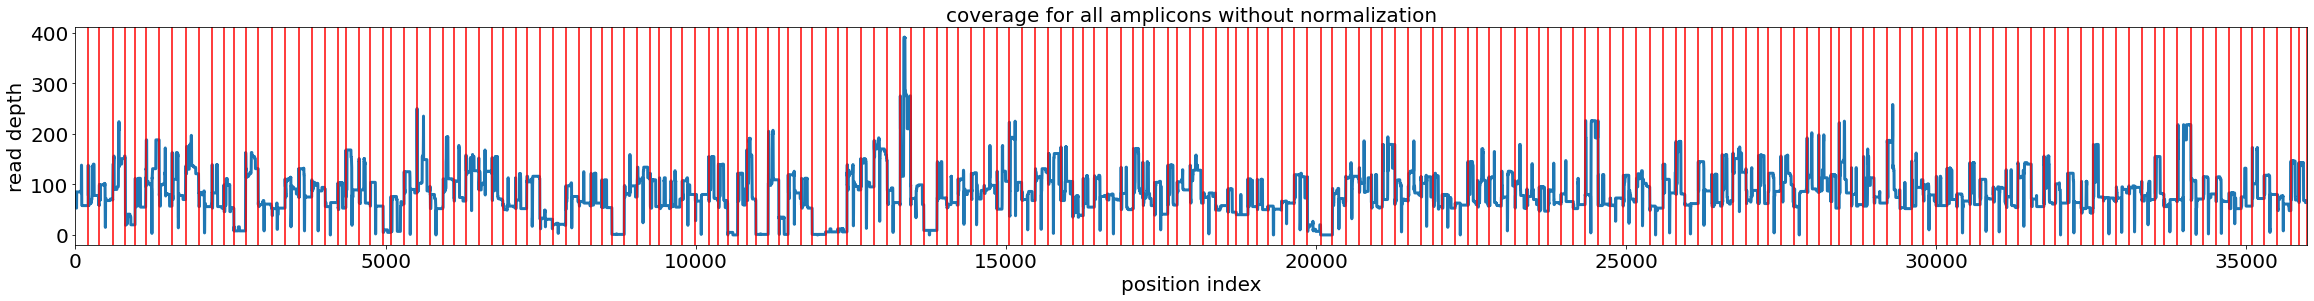

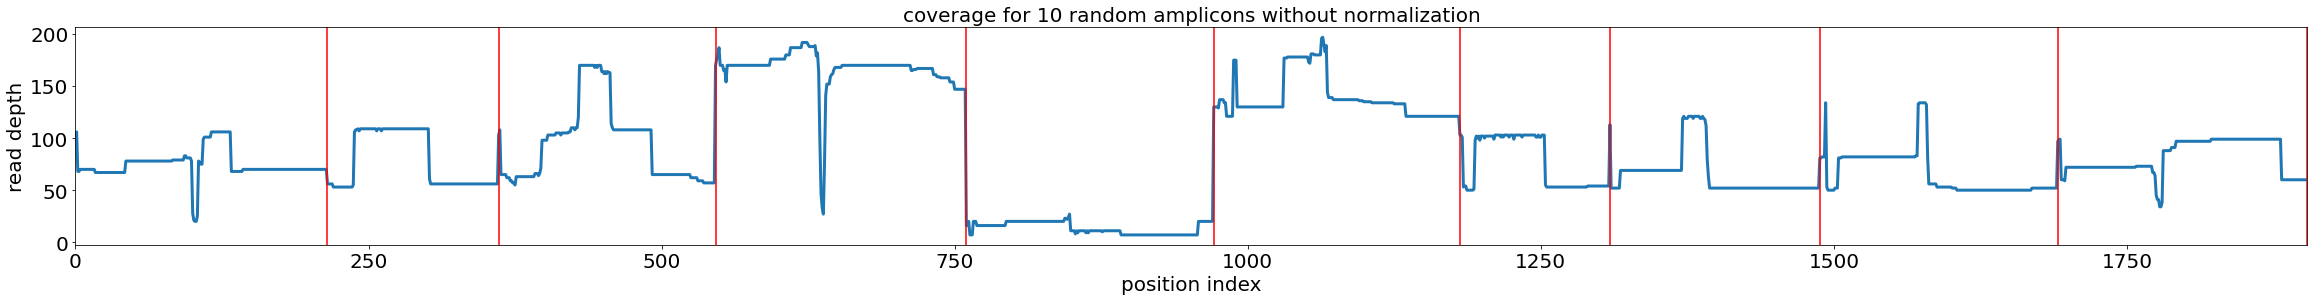

In [47]:
plot_cell_coverage(0, norm_flag=False)
plot_cell_coverage(0, nprobe = 10, norm_flag=False)

In [48]:
probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9]

In [51]:
def plot_quantile_distribution(probe_quantile=[0.1, 0.25, 0.4, 0.6, 0.75, 0.9], trim_perc = 0, read_depth_threshold = 0):

    qrecord = None
    for amplicon in amplicon_list:
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        median_depths = np.median(a, axis = 0)
        a_filtered = a[:, median_depths > read_depth_threshold]
        a_filtered_normalized = a_filtered / np.median(a_filtered, axis = 0)

        if qrecord is not None:
            qrecord = np.hstack((qrecord, np.quantile(a_filtered_normalized, probe_quantile, axis = 0)))
        else:
            qrecord = np.quantile(a_filtered_normalized, probe_quantile, axis = 0)
        
    return qrecord
#     for idx in len(probe_quantile):
#         fig, ax = plt.subplots(1,1,figsize=(6,4))
#         plt.hist(qrecord[idx,:], bins = 20)
#         plt.gca().set_ylabel(f"({probe_quantile[idx]}th quantile)/median")
#         plt.gca().set_xlabel(f"# amplicons across cells")

In [52]:
qrecord = plot_quantile_distribution()

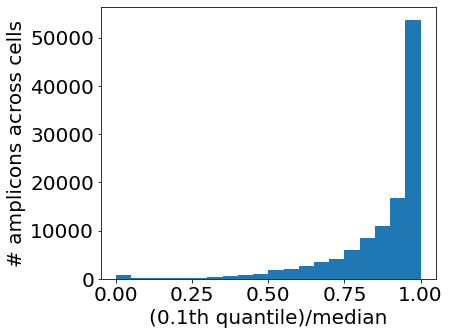

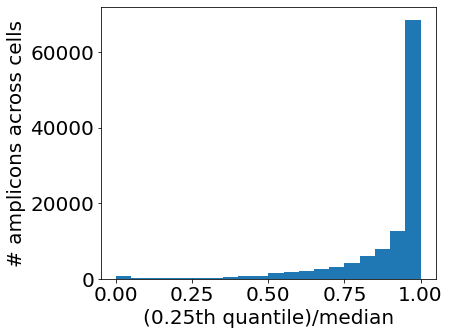

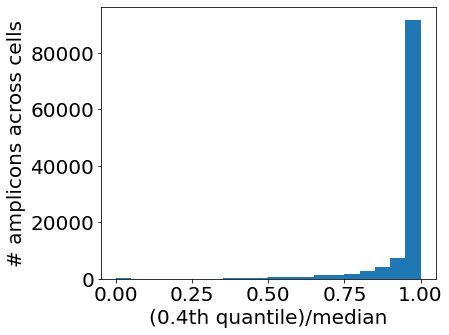

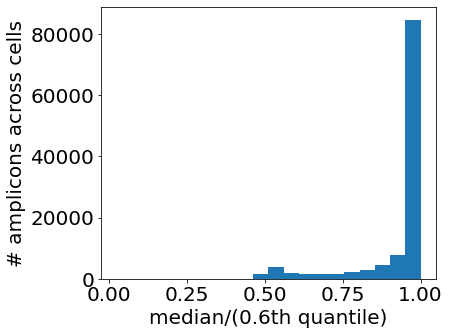

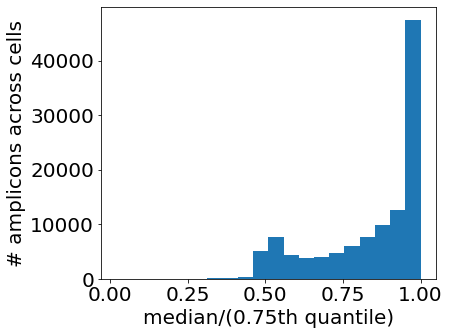

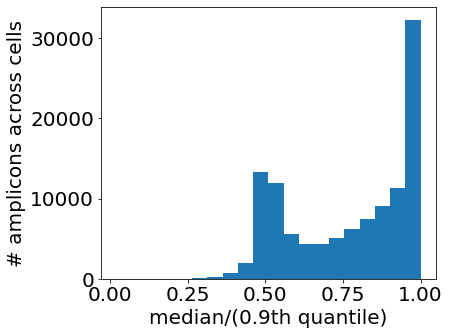

In [53]:
for idx in range(len(probe_quantile)):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    if probe_quantile[idx] > 0.5:
        plt.hist(np.reciprocal(qrecord[idx,:]), bins = 20)
        plt.gca().set_xlabel(f"median/({probe_quantile[idx]}th quantile)")
    else:
        plt.hist(qrecord[idx,:], bins = 20)
        plt.gca().set_xlabel(f"({probe_quantile[idx]}th quantile)/median")
    plt.gca().set_ylabel(f"# amplicons across cells")
#     if probe_quantile[idx] > 0.5:
#         plt.xlim((1,15))

In [57]:
def get_read_depth_heatmap(amplicon_threshold = 0, trim_perc = 0, read_depth_threshold = 0):
    
    namplicon = len(amplicon_list)
    read_depth = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_unique_pos[df_unique_pos['amplicon'] == amplicon]['index'].values

        npos = len(selected_indices)
        if trim_perc > 0:
            cutoff = int(npos // (100 / trim_perc))
        else:
            cutoff = 0

        a = ds.layers['DP'][selected_indices[cutoff:npos-cutoff], :]    

        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    read_depth = read_depth[:, np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon]

    return read_depth

In [58]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0, read_depth_threshold = 0)

In [59]:
# np.median(normalized_read_depth, axis = 1).shape

In [60]:
read_depth.shape

(186, 635)

In [61]:
np.sum(read_depth, axis = 0).shape

(635,)

In [62]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 40.75, 'cells')

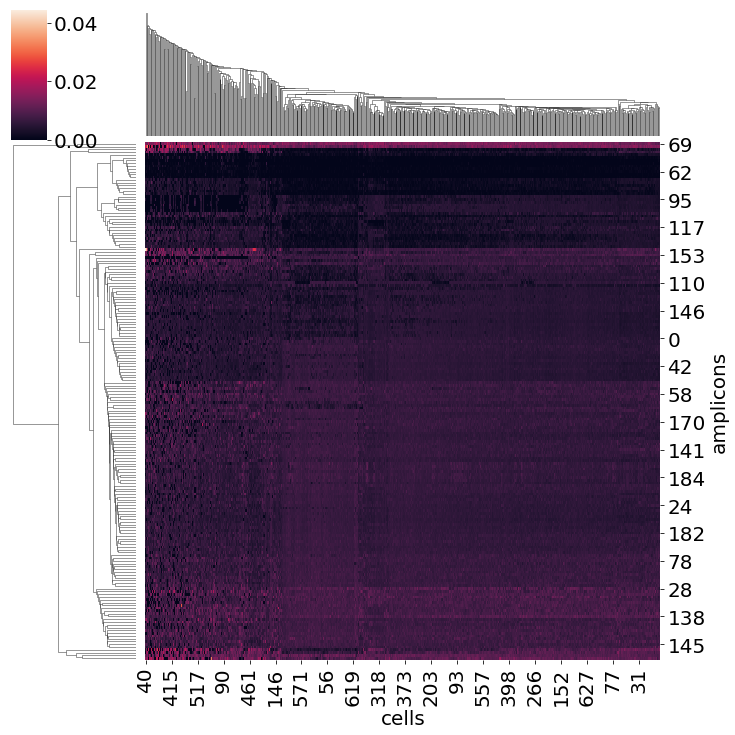

In [63]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [89]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 40.75, 'cells')

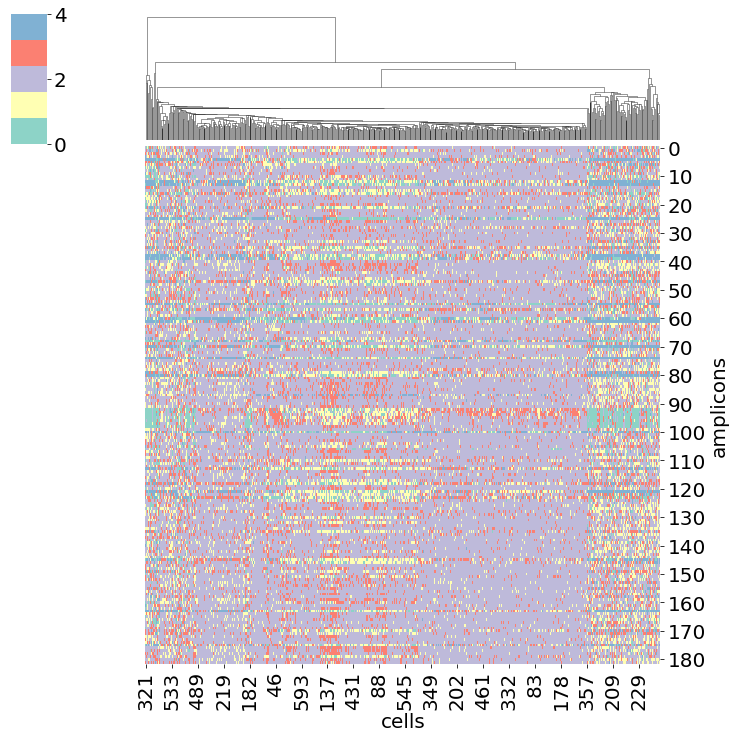

In [90]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=False, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [91]:
relative_normalized_read_depth.shape

(182, 615)

**We filter the cells with low coverage this time**

In [92]:
read_depth = get_read_depth_heatmap(amplicon_threshold=0.8, read_depth_threshold = 10)

In [93]:
read_depth.shape

(186, 615)

In [94]:
# normalize the read depth of each cell by the total reads of that cell
normalized_read_depth = read_depth / np.sum(read_depth, axis = 0)[None,:]

Text(0.5, 40.75, 'cells')

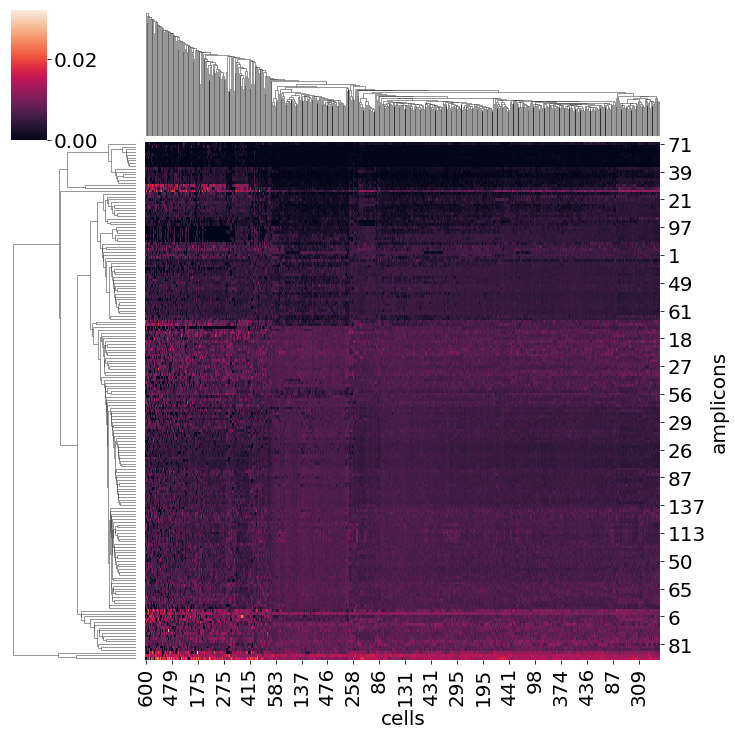

In [95]:
g = sns.clustermap(normalized_read_depth, row_cluster=True, col_cluster=True)
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [71]:
# remove amplicons with meidan read depth = 0 across all cells
relative_normalized_read_depth = normalized_read_depth[np.median(normalized_read_depth, axis = 1) > 0, :]
# further normalize the read depth in each amplicon by the median read depth of that amplicon across all cells
relative_normalized_read_depth = relative_normalized_read_depth / np.median(relative_normalized_read_depth, axis = 1)[:, None]

Text(0.5, 40.75, 'cells')

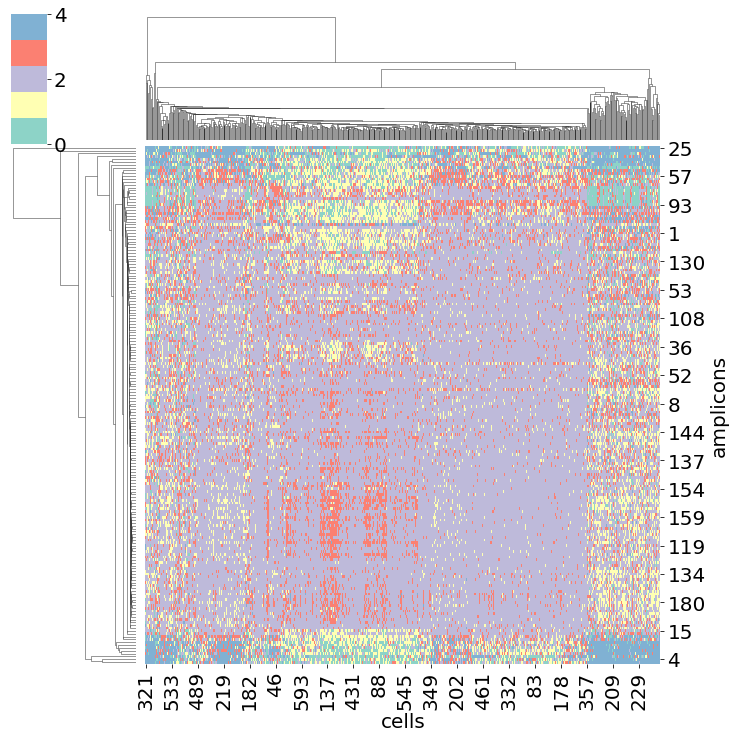

In [72]:
g = sns.clustermap(relative_normalized_read_depth*2, row_cluster=True, col_cluster=True, vmin=0, vmax=4, cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('amplicons', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

#### construct condensed VAF matrix

In [116]:
ds.layers['AD'].shape

(39772, 635)

In [60]:
def get_condensed_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.25, presence_threshold = 0.05, amplicon_threshold=0.8):
    
    namplicon = len(amplicon_list)
    vaf_mat = None
    read_depth_mat = None
    read_depth = None
    cum_pos_indices = None
    cum_cell_indices = None
    for idx, amplicon in enumerate(amplicon_list):
        selected_indices = df_pos[df_pos['amplicon'] == amplicon]['index'].values
        
        b = ds.layers['AD'][selected_indices, :]
        a = ds.layers['DP'][selected_indices, :]
        
        # build read depth mat
        if read_depth is not None:
            read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
        else:
            read_depth = np.median(a, axis = 0)        
        
        # remove positions with median read depth less than read_depth_threshold
        selected_indices = selected_indices[np.median(a, axis = 1) >= read_depth_threshold][:,None]
        b = b[np.median(a, axis = 1) >= read_depth_threshold, :]
        a = a[np.median(a, axis = 1) >= read_depth_threshold, :]        

        if vaf_mat is not None:
            vaf_mat = np.vstack((vaf_mat, b / a))
            read_depth_mat = np.vstack((read_depth_mat, a))
        else:
            vaf_mat = b / a
            read_depth_mat = a
        
        if cum_pos_indices is not None:
            cum_pos_indices = np.vstack((cum_pos_indices, selected_indices))
        else:
            cum_pos_indices = selected_indices.copy()

    ncells = vaf_mat.shape[1]
    cum_cell_indices = np.arange(ncells)
    
    # selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
    if amplicon_threshold > 0:
        curr_selected_indices = np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon
        vaf_mat = vaf_mat[:, curr_selected_indices]
        read_depth_mat = read_depth_mat[:, curr_selected_indices]
        cum_cell_indices = cum_cell_indices[curr_selected_indices]

    # remove positions with max vaf less than vaf_threshold
    curr_selected_indices = np.nanmax(vaf_mat, axis = 1) >= vaf_threshold
    cum_pos_indices = cum_pos_indices[curr_selected_indices]
    vaf_mat = vaf_mat[curr_selected_indices, :]
    read_depth_mat = read_depth_mat[curr_selected_indices, :]
    
    # remove positions with vaf less than vaf_threshold in less than presense_threshold fraction of the cells
    ncells = vaf_mat.shape[1]
    vaf_threshold_cell_count = (np.nan_to_num(vaf_mat) >= vaf_threshold).sum(axis = 1)
    curr_selected_indices = vaf_threshold_cell_count >= presence_threshold*ncells
    cum_pos_indices = cum_pos_indices[curr_selected_indices]
    vaf_mat = vaf_mat[curr_selected_indices, :]
    read_depth_mat = read_depth_mat[curr_selected_indices, :]
    
    return vaf_mat, read_depth_mat, cum_pos_indices.flatten(), cum_cell_indices

In [61]:
condensed_vaf_mat, read_depth_mat, pos_indices, cell_indices = get_condensed_vaf_matrix(amplicon_threshold = 0) 

<ipython-input-60-0433fcf0624d>:30: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = b / a
<ipython-input-60-0433fcf0624d>:27: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = np.vstack((vaf_mat, b / a))


In [62]:
condensed_vaf_mat.shape

(294, 635)

Text(0.5, 40.75, 'cells')

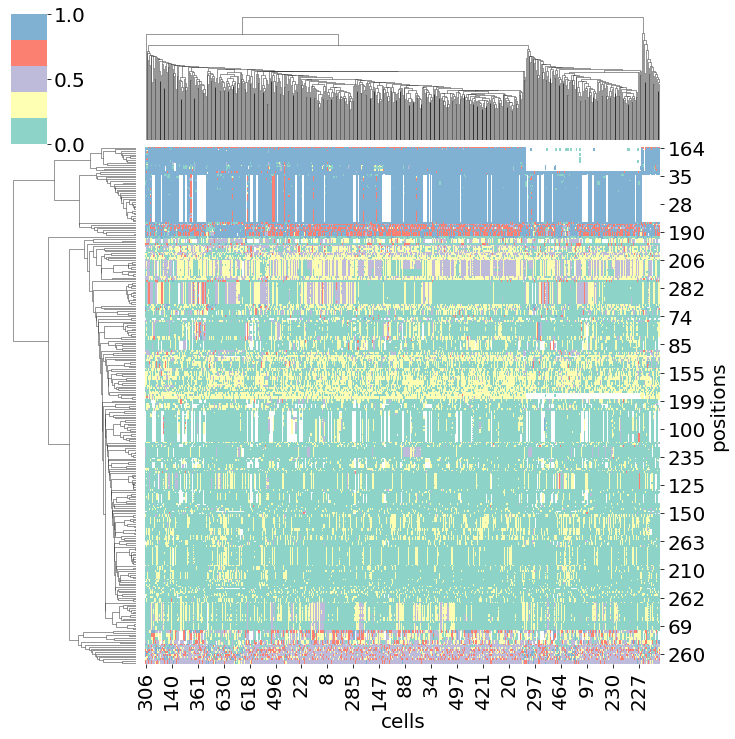

In [64]:
# masking entries with read dpeth less than 10
g = sns.clustermap(np.nan_to_num(condensed_vaf_mat), mask= read_depth_mat < 10, row_cluster=True, col_cluster=True, vmin=0, vmax=1,
                   cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [70]:
selected_vaf_mat, selected_read_depth_mat, selected_pos_indices, selected_cell_indices = get_condensed_vaf_matrix(amplicon_threshold = 0, presence_threshold = 0.2, vaf_threshold=0.33) 

<ipython-input-60-0433fcf0624d>:30: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = b / a
<ipython-input-60-0433fcf0624d>:27: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = np.vstack((vaf_mat, b / a))


In [71]:
selected_vaf_mat.shape

(126, 635)

Text(0.5, 40.75, 'cells')

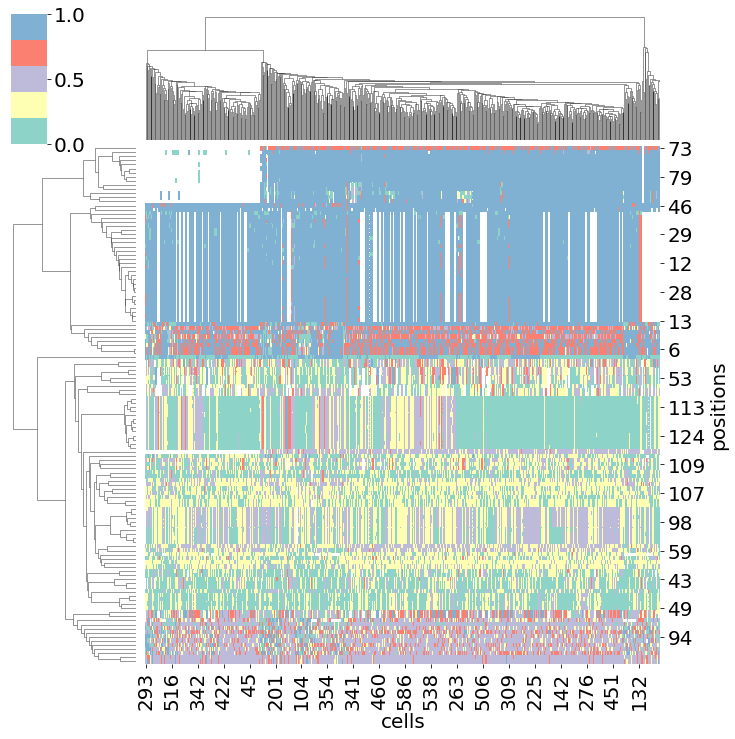

In [72]:
# masking entries with read dpeth less than 10
g = sns.clustermap(np.nan_to_num(selected_vaf_mat), mask= selected_read_depth_mat < 10, row_cluster=True, col_cluster=True, vmin=0, vmax=1,
                   cmap=sns.mpl_palette("Set3",5))
g.ax_heatmap.set_ylabel('positions', fontsize=20)
g.ax_heatmap.set_xlabel('cells', fontsize=20)

In [73]:
def write_snv_mat(dest_prefix, vaf_mat, read_depth_mat, pos_indices, cell_indices, mutation_presence_threshold=0.2, homozygous_mutation_threshold=0.8):
    snv_mat = np.zeros(vaf_mat.shape)
    snv_mat[vaf_mat < mutation_presence_threshold] = 0
    snv_mat[vaf_mat >= homozygous_mutation_threshold] = 2
    snv_mat[(vaf_mat >= mutation_presence_threshold) & (vaf_mat < homozygous_mutation_threshold)] = 1
    snv_mat[np.isnan(vaf_mat)] = 3
    snv_mat = snv_mat.astype(int)
    
    np.savetxt(f"{dest_prefix}_scite_snv_mat.txt", snv_mat, delimiter=" ", fmt='%d')
    df_pos.set_index('index').loc[pos_indices].reset_index().drop(['ref_len', 'alt_len', 'normal'], axis=1).to_csv(f'{dest_prefix}_pos_indices.csv', sep=',', index=False)
    
    snv_mat_str = snv_mat.astype(str)
    snv_mat_str = np.char.replace(snv_mat_str, '3', '?').T
    snv_mat_phiscs = np.vstack((np.hstack((np.array([['cell_idx/mut_idx']]), pos_indices[None, :].astype(str))), np.hstack((cell_indices[:,None], snv_mat_str))))
    np.savetxt(f"{dest_prefix}_phiscs_snv_mat.txt", snv_mat_phiscs, delimiter=" ", fmt='%s')
    
    return snv_mat

In [74]:
snv_mat = write_snv_mat('data/E1_selected', selected_vaf_mat, selected_read_depth_mat, selected_pos_indices, selected_cell_indices, mutation_presence_threshold=0.2, homozygous_mutation_threshold=0.8)

In [77]:
snv_mat.shape

(126, 635)

# investigate 5 positions present in primary and liver_met but not in E1

positions_of_interest = {10270747, 47039734, 151962055, 151962062, 151962068}

correpsonding amplicons -- AMPL70499, AMPL87417, AMPL87312, AMPL87312, AMPL87312

corresponding chromosomes -- 19, X, 7, 7, 7

In [17]:
positions_of_interest = {10270747, 47039734, 151962055, 151962062, 151962068}

1414
1415
1416
1417
38111


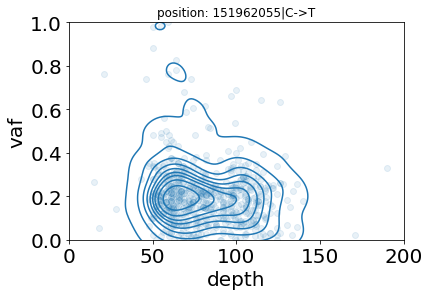

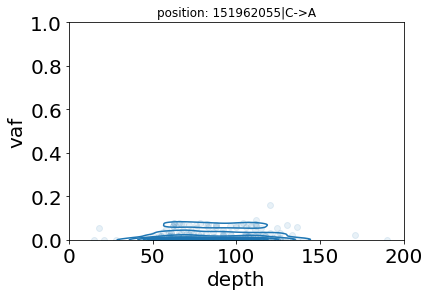

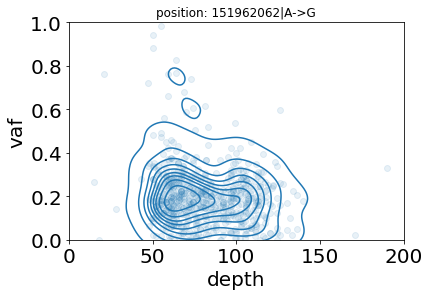

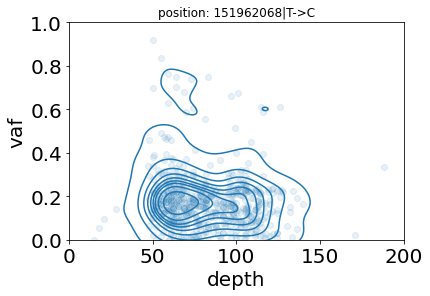

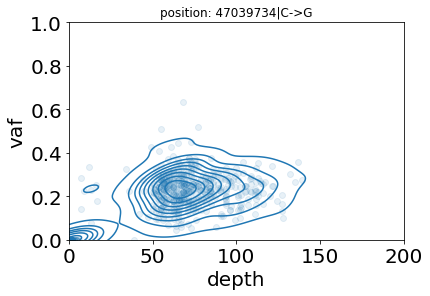

In [166]:
for idx, row in df_pos[df_pos.pos.isin(positions_of_interest)].iterrows():
    selected_index = row['index']
    print(selected_index)
    
    b = ds.layers['AD'][selected_index, :]
    a = ds.layers['DP'][selected_index, :]
    
    # select cells with read depth more than 0
    b = b[a > 0]
    a = a[a > 0]
    
    vaf = b / a
    
#     fig, ax = plt.subplots(1,1)
#     plt.hist(vaf_mat)
#     plt.title(f"position: {row['pos']}, vaf")
    
#     fig, ax = plt.subplots(1,1)
#     plt.hist(a)    
#     plt.title(f"position: {row['pos']}, read depth")
    
    fig, ax = plt.subplots(1,1)
    plt.scatter(a, vaf, alpha=0.1)
    df_plot = pd.DataFrame({'depth': list(a), 'vaf': list(vaf)})
    sns.kdeplot(data=df_plot, x='depth', y='vaf')
    plt.gca().set_xlim([0, 200])
    plt.gca().set_ylim([0, 1])
    plt.title(f"position: {row['pos']}|{row['ref']}->{row['alt']}")

In [151]:
geyser = sns.load_dataset("geyser")

In [152]:
geyser

,duration,waiting,kind
0,3.600,79,long
1,1.800,54,short
2,3.333,74,long
3,2.283,62,short
4,4.533,85,long
...,...,...,...
267,4.117,81,long
268,2.150,46,short
269,4.417,90,long
270,1.817,46,short


In [130]:
vaf_mat.shape

(635,)

(array([121., 210., 202.,  64.,  15.,   6.,   7.,   5.,   2.,   3.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

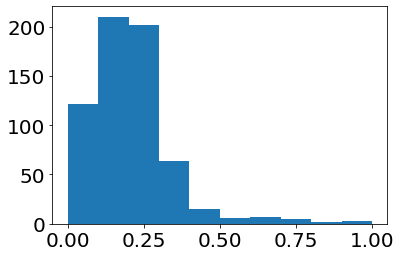

In [131]:
plt.hist(vaf_mat)

In [125]:
a.shape

(635,)

(array([  4.,   8., 212., 156., 122., 103.,  27.,   1.,   1.,   1.]),
 array([ 15. ,  32.5,  50. ,  67.5,  85. , 102.5, 120. , 137.5, 155. ,
        172.5, 190. ]),
 <BarContainer object of 10 artists>)

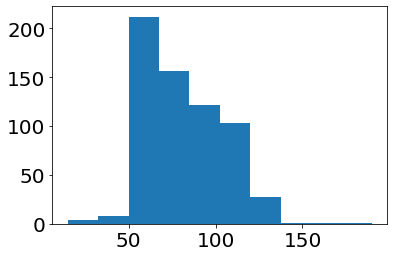

In [128]:
plt.hist(a)

In [127]:
np.histogram(a)

(array([  4,   8, 212, 156, 122, 103,  27,   1,   1,   1]),
 array([ 15. ,  32.5,  50. ,  67.5,  85. , 102.5, 120. , 137.5, 155. ,
        172.5, 190. ]))

In [123]:
b.shape

(635,)

In [23]:
df_pos[(df_pos['amplicon'] == 'AMPL70499') & (df_pos['pos'] > 10270740)]['pos'].sort_values()

3002     10270741
35408    10270742
35409    10270743
35410    10270744
35411    10270745
3005     10270746
3004     10270746
3003     10270746
35412    10270748
35413    10270748
35414    10270749
3006     10270750
35415    10270751
35416    10270752
35417    10270753
35418    10270754
35419    10270755
Name: pos, dtype: int32

In [96]:
amplicons_of_interest = ['AMPL70499', 'AMPL87417', 'AMPL87312']

In [99]:
a.shape

(241, 635)

In [100]:
read_depth.shape

(2, 635)

In [105]:
cum_pos_indices[:, np.newaxis].shape

(214, 1)

In [103]:
selected_indices.shape

(241,)

In [106]:
vaf_mat = None
read_depth_mat = None
read_depth = None
cum_pos_indices = None
cum_cell_indices = None

for amplicon in amplicons_of_interest:
    selected_indices = df_pos[df_pos['amplicon'] == amplicon]['index'].values
    
    b = ds.layers['AD'][selected_indices, :]
    a = ds.layers['DP'][selected_indices, :]
    
    if read_depth is not None:
        read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
    else:
        read_depth = np.median(a, axis = 0)        

    if vaf_mat is not None:
        vaf_mat = np.vstack((vaf_mat, b / a))
        read_depth_mat = np.vstack((read_depth_mat, a))
    else:
        vaf_mat = b / a
        read_depth_mat = a

    if cum_pos_indices is not None:
        cum_pos_indices = np.vstack((cum_pos_indices, selected_indices[:, np.newaxis]))
    else:
        cum_pos_indices = selected_indices[:, np.newaxis].copy()

/tmp/ipykernel_1321/955655219.py:22: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = b / a
/tmp/ipykernel_1321/955655219.py:19: RuntimeWarning: invalid value encountered in true_divide
  vaf_mat = np.vstack((vaf_mat, b / a))


In [108]:
vaf_mat.shape

(667, 635)

In [112]:
for idx in df_pos[df_pos.pos.isin(positions_of_interest)]['index']:
    if idx in cum_pos_indices:
        print('yes')

yes
yes
yes
yes
yes


In [141]:
df_pos[df_pos['alt'] == '']['amplicon'].value_counts()

AMPL45911    148
AMPL87311    147
AMPL40069    145
AMPL41862    144
AMPL70357    140
            ... 
AMPL70463     45
AMPL70415     45
AMPL87249     44
AMPL87385     44
AMPL59385     44
Name: amplicon, Length: 186, dtype: int64

In [140]:
df_pos[df_pos['alt'] == '']

,pos,chrom,amplicon,ref,alt,ref_len,alt_len,normal,index
3497,27057561,1,AMPL50980,C,,1,0,False,3497
3499,27057563,1,AMPL50980,G,,1,0,False,3499
3502,27057566,1,AMPL50980,C,,1,0,False,3502
3504,27057568,1,AMPL50980,T,,1,0,False,3504
3511,27057574,1,AMPL50980,C,,1,0,False,3511
...,...,...,...,...,...,...,...,...,...
39760,76777886,X,AMPL70504,G,,1,0,False,39760
39761,76777887,X,AMPL70504,C,,1,0,False,39761
39762,76777888,X,AMPL70504,A,,1,0,False,39762
39766,76777891,X,AMPL70504,T,,1,0,False,39766


In [ ]:
# def get_condensed_vaf_matrix(read_depth_threshold = 10, vaf_threshold = 0.25, presence_threshold = 0.05, amplicon_threshold=0.8):
    
namplicon = len(amplicon_list)
vaf_mat = None
read_depth_mat = None
read_depth = None
cum_pos_indices = None
cum_cell_indices = None
for idx, amplicon in enumerate(amplicon_list):
    selected_indices = df_pos[df_pos['amplicon'] == amplicon]['index'].values

    b = ds.layers['AD'][selected_indices, :]
    a = ds.layers['DP'][selected_indices, :]

    # build read depth mat
    if read_depth is not None:
        read_depth = np.vstack((read_depth, np.median(a, axis = 0)))
    else:
        read_depth = np.median(a, axis = 0)        

    # remove positions with median read depth less than read_depth_threshold
    selected_indices = selected_indices[np.median(a, axis = 1) >= read_depth_threshold][:,None]
    b = b[np.median(a, axis = 1) >= read_depth_threshold, :]
    a = a[np.median(a, axis = 1) >= read_depth_threshold, :]        

    if vaf_mat is not None:
        vaf_mat = np.vstack((vaf_mat, b / a))
        read_depth_mat = np.vstack((read_depth_mat, a))
    else:
        vaf_mat = b / a
        read_depth_mat = a

    if cum_pos_indices is not None:
        cum_pos_indices = np.vstack((cum_pos_indices, selected_indices))
    else:
        cum_pos_indices = selected_indices.copy()

ncells = vaf_mat.shape[1]
cum_cell_indices = np.arange(ncells)

# selecting the cells in which the read depth is more than read depth threshold for at least amplicon threshold percent of the amplicons
if amplicon_threshold > 0:
    curr_selected_indices = np.sum(read_depth >= read_depth_threshold, axis = 0) >= amplicon_threshold*namplicon
    vaf_mat = vaf_mat[:, curr_selected_indices]
    read_depth_mat = read_depth_mat[:, curr_selected_indices]
    cum_cell_indices = cum_cell_indices[curr_selected_indices]

# remove positions with max vaf less than vaf_threshold
curr_selected_indices = np.nanmax(vaf_mat, axis = 1) >= vaf_threshold
cum_pos_indices = cum_pos_indices[curr_selected_indices]
vaf_mat = vaf_mat[curr_selected_indices, :]
read_depth_mat = read_depth_mat[curr_selected_indices, :]

# remove positions with vaf less than vaf_threshold in less than presense_threshold fraction of the cells
ncells = vaf_mat.shape[1]
vaf_threshold_cell_count = (np.nan_to_num(vaf_mat) >= vaf_threshold).sum(axis = 1)
curr_selected_indices = vaf_threshold_cell_count >= presence_threshold*ncells
cum_pos_indices = cum_pos_indices[curr_selected_indices]
vaf_mat = vaf_mat[curr_selected_indices, :]
read_depth_mat = read_depth_mat[curr_selected_indices, :]

# return vaf_mat, read_depth_mat, cum_pos_indices.flatten(), cum_cell_indices